# Import libraries and packages

In [13]:
!ls

killings_with_county_dem_and_police_info.csv  QSVM-baseline.ipynb
qiskit-textbook				      Untitled.ipynb
qiskit-tutorials


In [2]:
# import qiskit library
import qiskit
import cvxpy # dependency needed for QSVM

Matplotlib is building the font cache; this may take a moment.


In [15]:
# for plotting
import matplotlib.pyplot as plt
# for matrix and linear algebra
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# preinstalled dataset
from qiskit.ml.datasets import ad_hoc_data
# basic simulator
from qiskit import BasicAer
# import Quantm Instance to run the experiment
from qiskit.aqua import QuantumInstance
# import quantum feature map
from qiskit.circuit.library import ZZFeatureMap
# import Quantum Support vector Machine model
from qiskit.aqua.algorithms import QSVM
# import several useful unitilies
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
#
print("Necessary libraries and packages are imported successfully!")

Necessary libraries and packages are imported successfully!


# Setup parameters

In [67]:
# feature dimension
feature_dim = 2
# size of the training dataset
trainning_dataset_size = 20
# size of the testing dataset
testing_dataset_size = 10
# set the seeds for the random number generator
random_seed = 42
# set shots/ number of iteration
shot = 10000

In [68]:
rawdat = pd.read_csv('killings_with_county_dem_and_police_info.csv', low_memory=False)
rawdat.shape

(2546, 339)

# Setup data

In [100]:
modeldat = rawdat.dropna(subset = ['calc_killed_by_police_per_10k_arrests', 'age', 'POP_ESTIMATE_2016'],how='any')
modeldat.shape

In [103]:
X_train, X_test, y_train, y_test = train_test_split(modeldat[['age', 'POP_ESTIMATE_2016']], 
                                                    modeldat['calc_killed_by_police_per_10k_arrests'], 
                                                    test_size=0.33, random_state=42)

X_train={'dat': X_train.to_numpy()}
X_test={'dat': X_test.to_numpy()}

In [104]:
# # set the dataset
# sample_Total, train_input, test_input, class_labels = ad_hoc_data(training_size=trainning_dataset_size, 
#                                                                     test_size=testing_dataset_size, 
#                                                                     gap=0.3,
#                                                                     n=feature_dim, 
#                                                                     plot_data=True)
# "gap": is the assumed gap between dimention in high dimensional space
#
#set the data points
datapoints, class_to_label = split_dataset_to_data_and_labels(X_train)
datapoints

[array([[2.10000e+01, 1.43030e+04],
        [2.50000e+01, 1.49382e+05],
        [2.70000e+01, 1.37280e+04],
        ...,
        [3.70000e+01, 3.91843e+05],
        [2.30000e+01, 7.55640e+04],
        [2.60000e+01, 7.48178e+05]]),
 array([0, 0, 0, ..., 0, 0, 0])]

In [105]:
X_train

{'dat': array([[2.10000e+01, 1.43030e+04],
        [2.50000e+01, 1.49382e+05],
        [2.70000e+01, 1.37280e+04],
        ...,
        [3.70000e+01, 3.91843e+05],
        [2.30000e+01, 7.55640e+04],
        [2.60000e+01, 7.48178e+05]])}

# Setup the backend to run the QSVM

In [107]:
# use the qasm simulator
backend = BasicAer.get_backend('qasm_simulator')
# define the feature map
"""
Feature Map: 
    a mapping / transformation process which maps the data points from the original plane or space into a much higher dimensional space.
    
    Arg: 
    reps: The number of repeated circuits
    feature_dimension: Number of features.
"""
feature_map = ZZFeatureMap(feature_dim, reps=2)
# define the QSVM model
qsvm = QSVM(feature_map, X_train, X_test, None)
# set the random seed for this qsvm
qsvm.random_seed = random_seed
# setup the quantum instance to run the experiment
quantum_instance = QuantumInstance(backend, shots=shot, seed_simulator=random_seed, seed_transpiler=random_seed)

## This one is still running

In [ ]:
# get the result from the above designed experiment on the quantum_instance
result = qsvm.run(quantum_instance)

In [9]:
print(feature_map)

     ┌───┐┌──────────────┐                                           ┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           
«q_0: ┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └──────────────┘└───┘└───────────────────────────────┘└───┘


## So, this quantum circuit maps our dataset into a much higher dimensional space.





## Check the 'Kernel Matrix' from the 'result'  

**Kernel Matrix**: a sort of distance between points in higher dimension


  Kernel Matrix during the training:



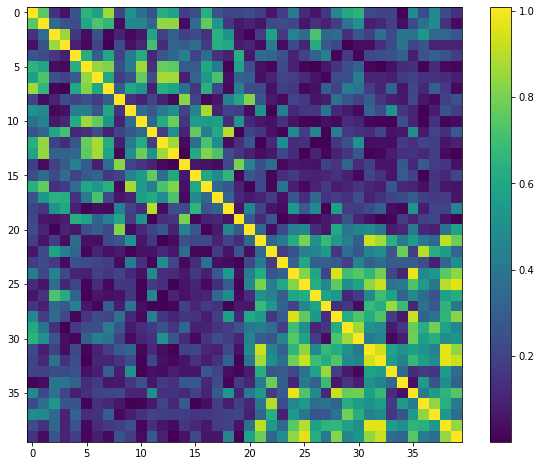

In [10]:
print("\n  Kernel Matrix during the training:\n")
kernel_matrix = result['kernel_matrix_training']
# plot this kernel matrix
plt.figure(figsize=(10, 8))
img = plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='viridis')
plt.colorbar()
plt.show()

## Explanation of this plot  

This plot shows the **kernel matrix** of the training result of the QSVM model/ algorithm. 
First, by applying the quantum feature map, ZZFeatureMap, to remap the dataset into a higher (vector) space. 
Second, calculate the inner product of each possible pair of data points. eg. the inner product of a vector with itself is one. those points at the diagonal are exactly the amplitude of an inner product of each vector with itself,i.e, |<1|1>|^2 = 1.0 ,  |<2|2>|^2 = 1.0,  |<19|19>|^2 = 1.0 , etc. Those dark points with value of zero correspond to the inner product of two orthogonal vectors. 

# Prediction

In [11]:
predicted_labels = qsvm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, qsvm.label_to_class)
print("Ground truth: {}".format(datapoints[1]))
print("Prediction: {}".format(predicted_labels))
# prediction accuracy
print("testing success ration: {}".format(result['testing_accuracy']))

Ground truth: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
testing success ration: 1.0
